# **Tensorflow Time Series of COVID-19 Confirmed U.S. Cases**

---



In [1]:
%tensorflow_version 1.x

TensorFlow 1.x selected.


## **Reading COVID-19 Data from STATWORX COVID19 API** 

In [0]:
import tensorflow as tf
tf.enable_eager_execution()

import matplotlib as mpl
import matplotlib.pyplot as plt
import numpy as np
import os
import pandas as pd
import requests
import json

mpl.rcParams['figure.figsize'] = (8, 6)
mpl.rcParams['axes.grid'] = False

# POST to API
payload = {'code': 'US'} # or {'code': 'DE'}
URL = 'https://api.statworx.com/covid'
response = requests.post(url=URL, data=json.dumps(payload))

# Convert to data frame
df = pd.DataFrame.from_dict(json.loads(response.text))

In [3]:
df.head()

,date,day,month,year,cases,deaths,country,code,population,continentExp,cases_cum,deaths_cum
0,2019-12-31,31,12,2019,0,0,United_States_of_America,US,327167434,America,0,0
1,2020-01-01,1,1,2020,0,0,United_States_of_America,US,327167434,America,0,0
2,2020-01-02,2,1,2020,0,0,United_States_of_America,US,327167434,America,0,0
3,2020-01-03,3,1,2020,0,0,United_States_of_America,US,327167434,America,0,0
4,2020-01-04,4,1,2020,0,0,United_States_of_America,US,327167434,America,0,0


In [27]:
df.tail()

,date,day,month,year,cases,deaths,country,code,population,continentExp,cases_cum,deaths_cum
119,2020-04-28,28,4,2020,22541,1369,United_States_of_America,US,327167434,America,988451,56245
120,2020-04-29,29,4,2020,24132,2110,United_States_of_America,US,327167434,America,1012583,58355
121,2020-04-30,30,4,2020,27326,2611,United_States_of_America,US,327167434,America,1039909,60966
122,2020-05-01,1,5,2020,29917,2040,United_States_of_America,US,327167434,America,1069826,63006
123,2020-05-02,2,5,2020,33955,2062,United_States_of_America,US,327167434,America,1103781,65068


### **Selecting the Date range to Index** 

---

The parameter history_size is the size of the past window of information. The target_size is how far in the future does the model need to learn to predict. The target_size is the label that needs to be predicted.

In [0]:
def univariate_data(dataset, start_index, end_index, history_size, target_size):
  data = []
  labels = []

  start_index = start_index + history_size
  if end_index is None:
    end_index = len(dataset) - target_size

  for i in range(start_index, end_index):
    indices = range(i-history_size, i)
    #Reshape data from (history_size,) to (history_size, 1)
    data.append(np.reshape(dataset[indices], (history_size, 1)))
    labels.append(dataset[i+target_size])
  return np.array(data), np.array(labels)

Splitting up training set

In [0]:
TRAIN_SPLIT = 74

Setting seed to ensure reproducibility.

In [0]:
tf.random.set_random_seed(13)

Extracting Cumulative Confirmed Cases

In [30]:
uni_data = df['cases_cum']
uni_data.index = df['date']
uni_data.head()

date
2019-12-31    0
2020-01-01    0
2020-01-02    0
2020-01-03    0
2020-01-04    0
Name: cases_cum, dtype: int64

In [29]:
uni_data.tail()

date
2020-04-28     988451
2020-04-29    1012583
2020-04-30    1039909
2020-05-01    1069826
2020-05-02    1103781
Name: cases_cum, dtype: int64

Plot of COVID-19 across time.

array([<matplotlib.axes._subplots.AxesSubplot object at 0x7fda4b63abe0>],
      dtype=object)

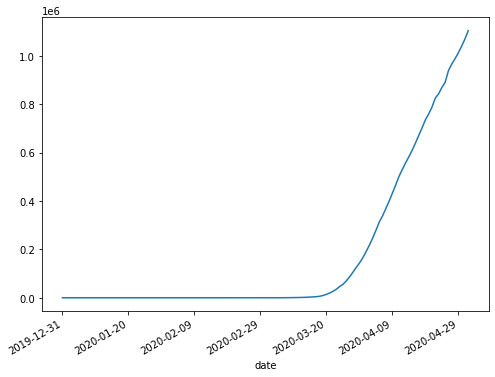

In [8]:
uni_data.plot(subplots=True)

In [0]:
uni_data = uni_data.values

In [0]:
uni_train_mean = uni_data[:TRAIN_SPLIT].mean()
uni_train_std = uni_data[:TRAIN_SPLIT].std()

Standardizing the data.

In [0]:
uni_data = (uni_data-uni_train_mean)/uni_train_std

## **Univariate model**

---



The model will be given the last 20 recorded day observations, for learning to predict the Confirmed Cases at the next time step.

In [0]:
univariate_past_history = 20
univariate_future_target = 0

x_train_uni, y_train_uni = univariate_data(uni_data, 0, TRAIN_SPLIT,
                                           univariate_past_history,
                                           univariate_future_target)
x_val_uni, y_val_uni = univariate_data(uni_data, TRAIN_SPLIT, None,
                                       univariate_past_history,
                                       univariate_future_target)

In [13]:
print ('Single window of past history')
print (x_train_uni[0])
print ('\n Target Cumulative Confirmed Cases to predict')
print (y_train_uni[0])

Single window of past history
[[-0.35604638]
 [-0.35604638]
 [-0.35604638]
 [-0.35604638]
 [-0.35604638]
 [-0.35604638]
 [-0.35604638]
 [-0.35604638]
 [-0.35604638]
 [-0.35604638]
 [-0.35604638]
 [-0.35604638]
 [-0.35604638]
 [-0.35604638]
 [-0.35604638]
 [-0.35604638]
 [-0.35604638]
 [-0.35604638]
 [-0.35604638]
 [-0.35604638]]

 Target cumulative confirmed to predict
-0.3560463830477833


The information given to the network is given in blue, and it must predict the value at the red cross.

In [0]:
def create_time_steps(length):
  return list(range(-length, 0))

In [0]:
def show_plot(plot_data, delta, title):
  labels = ['History', 'True Future', 'Model Prediction']
  marker = ['.-', 'rx', 'go']
  time_steps = create_time_steps(plot_data[0].shape[0])
  if delta:
    future = delta
  else:
    future = 0

  plt.title(title)
  for i, x in enumerate(plot_data):
    if i:
      plt.plot(future, plot_data[i], marker[i], markersize=10,
               label=labels[i])
    else:
      plt.plot(time_steps, plot_data[i].flatten(), marker[i], label=labels[i])
  plt.legend()
  plt.xlim([time_steps[0], (future+5)*2])
  plt.xlabel('Time-Step')
  return plt

<module 'matplotlib.pyplot' from '/usr/local/lib/python3.6/dist-packages/matplotlib/pyplot.py'>

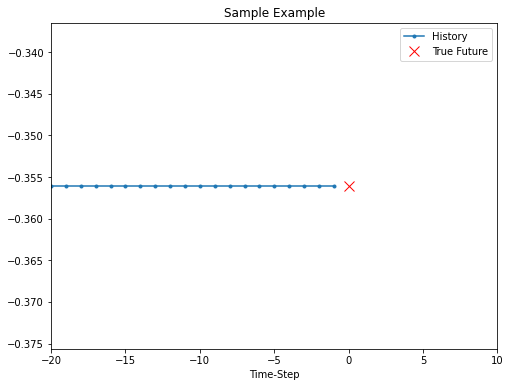

In [16]:
show_plot([x_train_uni[0], y_train_uni[0]], 0, 'Sample Example')

### **Baseline**

---


The sample baseline. Given an input point, the baseline method looks at all the history and predicts the next point to be the average of the last 20 observations.

In [0]:
def baseline(history):
  return np.mean(history)

<module 'matplotlib.pyplot' from '/usr/local/lib/python3.6/dist-packages/matplotlib/pyplot.py'>

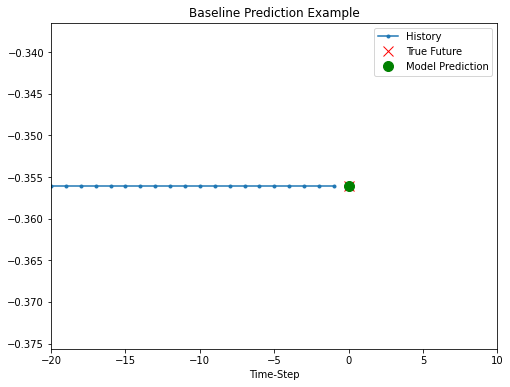

In [18]:
show_plot([x_train_uni[0], y_train_uni[0], baseline(x_train_uni[0])], 0,
           'Baseline Prediction Example')

In [19]:
BATCH_SIZE = 256
BUFFER_SIZE = 10000

train_univariate = tf.data.Dataset.from_tensor_slices((x_train_uni, y_train_uni))
train_univariate = train_univariate.cache().shuffle(BUFFER_SIZE).batch(BATCH_SIZE).repeat()

val_univariate = tf.data.Dataset.from_tensor_slices((x_val_uni, y_val_uni))
val_univariate = val_univariate.batch(BATCH_SIZE).repeat()

Instructions for updating:
Use tf.where in 2.0, which has the same broadcast rule as np.where


In [0]:
simple_lstm_model = tf.keras.models.Sequential([
    tf.keras.layers.LSTM(8, input_shape=x_train_uni.shape[-2:]),
    tf.keras.layers.Dense(1)
])

simple_lstm_model.compile(optimizer='adam', loss='mae')

In [21]:
for x, y in val_univariate.take(1):
    print(simple_lstm_model.predict(x).shape)

(30, 1)


In [25]:
EVALUATION_INTERVAL = 200
EPOCHS = 100

simple_lstm_model.fit(train_univariate, epochs=EPOCHS,
                      steps_per_epoch=EVALUATION_INTERVAL,
                      validation_data=val_univariate, validation_steps=50)

Train for 200 steps, validate for 50 steps
Epoch 1/100
200/200 [==============================] - 7s 36ms/step - loss: 0.0278 - val_loss: 2374.7280
Epoch 2/100
200/200 [==============================] - 7s 37ms/step - loss: 0.0226 - val_loss: 2374.8398
Epoch 3/100
200/200 [==============================] - 7s 37ms/step - loss: 0.0196 - val_loss: 2374.7617
Epoch 4/100
200/200 [==============================] - 7s 37ms/step - loss: 0.0179 - val_loss: 2374.7500
Epoch 5/100
200/200 [==============================] - 7s 36ms/step - loss: 0.0171 - val_loss: 2374.7615
Epoch 6/100
200/200 [==============================] - 7s 36ms/step - loss: 0.0167 - val_loss: 2374.7563
Epoch 7/100
200/200 [==============================] - 7s 36ms/step - loss: 0.0163 - val_loss: 2374.7515
Epoch 8/100
200/200 [==============================] - 7s 36ms/step - loss: 0.0161 - val_loss: 2374.7471
Epoch 9/100
200/200 [==============================] - 7s 37ms/step - loss: 0.0157 - val_loss: 2374.7449
Epoch 10/100

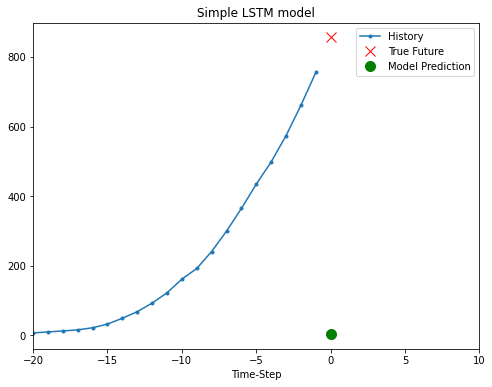

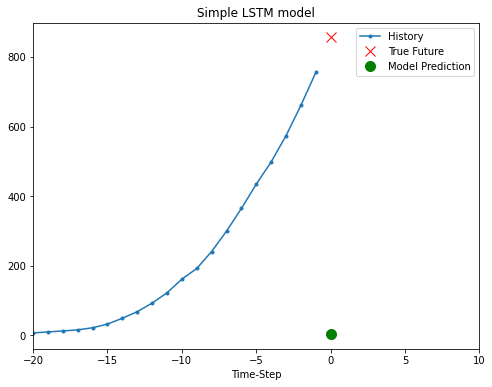

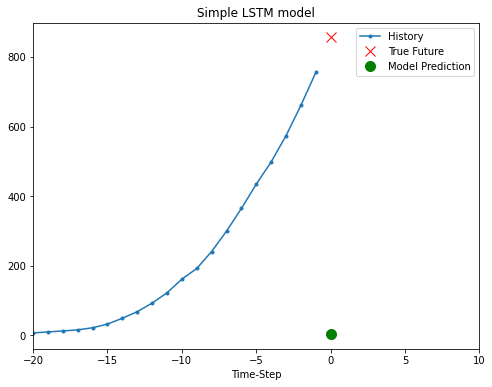

In [26]:
for x, y in val_univariate.take(3):
  plot = show_plot([x[0].numpy(), y[0].numpy(),
                    simple_lstm_model.predict(x)[0]], 0, 'Simple LSTM model')
  plot.show()